In [3]:
import hoomd
import numpy as np

In [4]:
import itertools
import math

In [14]:
import gsd.hoomd
import fresnel

In [6]:
m = 4
N_particles = 2 * m**3

In [7]:
spacing = 1.2
K = math.ceil(N_particles ** (1 / 3))
L = K * spacing

In [8]:
x = np.linspace(-L / 2, L / 2, K, endpoint=False)
position = list(itertools.product(x, repeat=3))
print(position[0:4])

[(np.float64(-3.5999999999999996), np.float64(-3.5999999999999996), np.float64(-3.5999999999999996)), (np.float64(-3.5999999999999996), np.float64(-3.5999999999999996), np.float64(-2.3999999999999995)), (np.float64(-3.5999999999999996), np.float64(-3.5999999999999996), np.float64(-1.1999999999999997)), (np.float64(-3.5999999999999996), np.float64(-3.5999999999999996), np.float64(0.0))]


In [9]:
position = position[0:N_particles]

In [11]:
orientation = [(1, 0, 0, 0)] * N_particles

In [39]:
# https://github.com/glotzerlab/hoomd-examples/blob/trunk-minor/00-Introducing-HOOMD-blue/04-Randomizing-the-System.ipynb
import warnings

import fresnel
import IPython
import packaging.version

device = fresnel.Device()
tracer = fresnel.tracer.Path(device=device, w=300, h=300)

FRESNEL_MIN_VERSION = packaging.version.parse('0.13.0')
FRESNEL_MAX_VERSION = packaging.version.parse('0.14.0')


def render(snapshot):
    if (
        'version' not in dir(fresnel)
        or packaging.version.parse(fresnel.version.version) < FRESNEL_MIN_VERSION
        or packaging.version.parse(fresnel.version.version) >= FRESNEL_MAX_VERSION
    ):
        warnings.warn(
            f'Unsupported fresnel version {fresnel.version.version} - expect errors.'
        )
    L = snapshot.configuration.box[0]
    vertices = [
        (-0.5, 0, 0),
        (0.5, 0, 0),
        (0, -0.5, 0),
        (0, 0.5, 0),
        (0, 0, -0.5),
        (0, 0, 0.5),
    ]
    poly_info = fresnel.util.convex_polyhedron_from_vertices(vertices)

    scene = fresnel.Scene(device)
    geometry = fresnel.geometry.ConvexPolyhedron(
        scene, poly_info, N=snapshot.particles.N
    )
    geometry.material = fresnel.material.Material(
        color=fresnel.color.linear([0.01, 0.74, 0.26]), roughness=0.5
    )
    geometry.position[:] = snapshot.particles.position[:]
    geometry.orientation[:] = snapshot.particles.orientation[:]
    geometry.outline_width = 0.01
    fresnel.geometry.Box(scene, snapshot.configuration.box, box_radius=0.02)

    scene.lights = [
        fresnel.light.Light(direction=(0, 0, 1), color=(0.8, 0.8, 0.8), theta=math.pi),
        fresnel.light.Light(
            direction=(1, 1, 1), color=(1.1, 1.1, 1.1), theta=math.pi / 3
        ),
    ]
    scene.camera = fresnel.camera.Orthographic(
        position=(L * 2, L, L * 2), look_at=(0, 0, 0), up=(0, 1, 0), height=L * 1.4 + 1
    )
    scene.background_alpha = 1
    scene.background_color = (1, 1, 1)
    return IPython.display.Image(tracer.sample(scene, samples=500)._repr_png_())

In [27]:
import os

fn = os.path.join(os.getcwd(), 'random.gsd')
![ -e "$fn" ] && rm "$fn"

In [32]:
frame = gsd.hoomd.Frame()
frame.particles.N = N_particles
frame.particles.position = position
frame.particles.orientation = orientation

In [33]:
frame.particles.typeid = [0] * N_particles
frame.particles.types = ['octahedron']
frame.configuration.box = [L, L, L, 0, 0, 0]

In [35]:
os.remove('lattice.gsd')
with gsd.hoomd.open(name='lattice.gsd', mode='x') as f:
    f.append(frame)

In [36]:
cpu = hoomd.device.CPU()
simulation = hoomd.Simulation(device=cpu, seed=20)

mc = hoomd.hpmc.integrate.ConvexPolyhedron()
mc.shape['octahedron'] = dict(
    vertices=[
        (-0.5, 0, 0),
        (0.5, 0, 0),
        (0, -0.5, 0),
        (0, 0.5, 0),
        (0, 0, -0.5),
        (0, 0, 0.5),
    ]
)

simulation.operations.integrator = mc
simulation.create_state_from_gsd(filename='lattice.gsd')

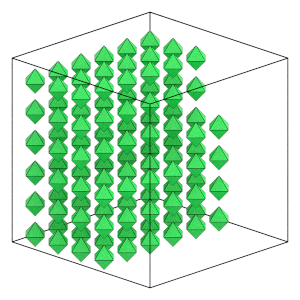

In [40]:
initial_snapshot = simulation.state.get_snapshot()
render(initial_snapshot)

In [41]:
simulation.run(10e3)
mc.translate_moves # (number of accepted moves, number of rejected moves)
mc.translate_moves[0] / sum(mc.translate_moves) # fraction of accepted moves
mc.rotate_moves # (accepted rotate moves, rejected rotate moves)
mc.rotate_moves[0] / sum(mc.rotate_moves) # fraction of accepted rotate moves
mc.overlaps # number of overlapping particles

0

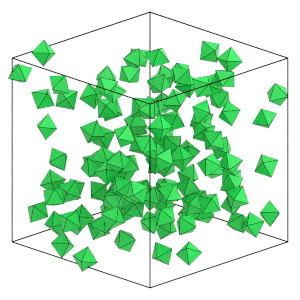

In [43]:
final_snapshot = simulation.state.get_snapshot()
render(final_snapshot)

In [44]:
hoomd.write.GSD.write(state=simulation.state, mode='xb', filename='random.gsd')